# TensorFlow Distributions: A Gentle Introduction

>[TensorFlow Distributions: A Gentle Introduction](#scrollTo=DcriL2xPrG3_)

>>[Basic Univariate Distributions](#scrollTo=QD5lzFZerG4H)

>>[Multivariate Distributions](#scrollTo=ztM2d-N9nNX2)

>>[Multiple Distributions](#scrollTo=57lLzC7MQV-9)

>>[Using Independent To Aggregate Batches to Events](#scrollTo=t52ptQXvUO07)

>>[Batches of Multivariate Distirbutions](#scrollTo=INu1viAVXz93)

>>[Broadcasting, aka Why Is This So Confusing?](#scrollTo=72uiME85SmEH)

>>[Going Farther](#scrollTo=JpjjIGThrj8Q)



In this notebook, we'll explore TensorFlow Distributions (TFD for short). The goal of this notebook is to get you gently up the learning curve, including understanding TFD's handling of tensor shapes. This notebook tries to present examples before rather than abstract concepts. We'll present canonical easy ways to do things first, and save the most general abstract view until the end. If you're the type who prefers a more abstract and reference-style tutorial, check out [Understanding TensorFlow Distributions Shapes](https://github.com/tensorflow/probability/blob/master/tensorflow_probability/examples/jupyter_notebooks/Understanding_TensorFlow_Distributions_Shapes.ipynb). If you have any questions about the material here, don't hesitate to contact (or join) [the TensorFlow Probability mailing list](https://groups.google.com/a/tensorflow.org/forum/#!forum/tfprobability). We're happy to help.

Before we start, we need to import the appropriate libraries. Our overall library is `tensorflow_probability`. By convention, we generally refer to the distributions library as `tfd`.

[Tensorflow Eager](https://www.tensorflow.org/guide/eager) is an imperative execution environment for TensorFlow. In TensorFlow eager, every TF operation is immediately evaluated and produces a result. This is in contrast to TensorFlow's standard "graph" mode, in which TF operations add nodes to a graph which is later executed. This entire notebook is written using TF Eager, although none of the concepts presented here rely on that, and TFP can be used in graph mode.

In [0]:
import collections

import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions

tfe = tf.contrib.eager
tfe.enable_eager_execution()

import matplotlib.pyplot as plt

from __future__ import print_function

## Basic Univariate Distributions


Let's dive right in and create a normal distribution:

In [0]:
n = tfd.Normal(loc=0., scale=1.)
n

<tf.distributions.Normal 'Normal/' batch_shape=() event_shape=() dtype=float32>

We can draw a sample from it:

In [0]:
n.sample()

<tf.Tensor: id=23, shape=(), dtype=float32, numpy=-0.16601132>

We can draw multiple samples:

In [0]:
n.sample(3)

<tf.Tensor: id=44, shape=(3,), dtype=float32, numpy=array([-0.740354  , -0.1778658 , -1.27472067], dtype=float32)>

We can evaluate a log prob:

In [0]:
n.log_prob(0.)

<tf.Tensor: id=55, shape=(), dtype=float32, numpy=-0.91893852>

We can evaluate multiple log probabilities:

In [0]:
n.log_prob([0., 2., 4.])

<tf.Tensor: id=64, shape=(3,), dtype=float32, numpy=array([-0.91893852, -2.91893864, -8.91893864], dtype=float32)>

We have a wide range of distributions. Let's try a Bernoulli:

In [0]:
b = tfd.Bernoulli(probs=0.7)
b

<tf.distributions.Bernoulli 'Bernoulli/' batch_shape=() event_shape=() dtype=int32>

In [0]:
b.sample()

<tf.Tensor: id=92, shape=(), dtype=int32, numpy=1>

In [0]:
b.sample(8)

<tf.Tensor: id=114, shape=(8,), dtype=int32, numpy=array([1, 0, 0, 1, 1, 1, 0, 0], dtype=int32)>

In [0]:
b.log_prob(1)

<tf.Tensor: id=129, shape=(), dtype=float32, numpy=-0.35667494>

In [0]:
b.log_prob([1, 0, 1, 0])

<tf.Tensor: id=149, shape=(4,), dtype=float32, numpy=array([-0.35667494, -1.20397282, -0.35667494, -1.20397282], dtype=float32)>

## Multivariate Distributions

We'll create a multivariate normal with a diagonal covariance:

In [0]:
nd = tfd.MultivariateNormalDiag(loc=[0., 10.], scale_diag=[1., 4.])
nd

<tf.distributions.MultivariateNormalDiag 'MultivariateNormalDiag/' batch_shape=() event_shape=(2,) dtype=float32>

Comparing this to the univariate normal we created earlier, what's different? 

In [0]:
tfd.Normal(loc=0., scale=1.)

<tf.distributions.Normal 'Normal/' batch_shape=() event_shape=() dtype=float32>

We see that the univariate normal has an `event_shape` of `()`, indicating it's a scalar distribution. The multivariate normal has an `event_shape` of `2`, indicating the basic [event space](https://en.wikipedia.org/wiki/Event_(probability_theory&#41;) of this distribution is two-dimensional.

Sampling works just as before:

In [0]:
nd.sample()

<tf.Tensor: id=317, shape=(2,), dtype=float32, numpy=array([ -2.16430044,  10.37543201], dtype=float32)>

In [0]:
nd.sample(5)

<tf.Tensor: id=425, shape=(5, 2), dtype=float32, numpy=
array([[ -0.21695504,  12.464674  ],
       [ -0.12954073,   8.3900528 ],
       [  0.05821768,   7.45994711],
       [ -0.76251912,  14.93200302],
       [  0.15911509,  10.37340355]], dtype=float32)>

In [0]:
nd.log_prob([0., 10])

<tf.Tensor: id=5090, shape=(3,), dtype=float32, numpy=array([-52.33789825, -49.81270218, -57.69403076], dtype=float32)>

Multivariate normals do not in general have diagonal covariance. TFD offers multiple ways to create multivariate normals, including a full-covariance specification, which we use here.

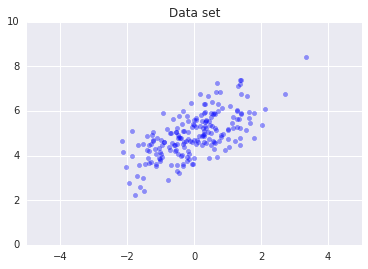

In [0]:
nd = tfd.MultivariateNormalFullCovariance(
    loc = [0., 5], covariance_matrix = [[1., .7], [.7, 1.]])
data = nd.sample(200)
plt.scatter(data[:, 0], data[:, 1], color='blue', alpha=0.4)
plt.axis([-5, 5, 0, 10])
plt.title("Data set")
plt.show()

## Multiple Distributions

Our first Bernoulli distribution represented a flip of a single fair coin. We can also create a batch of independent Bernoulli distributions, each with their own parameters, in a single `Distribution` object:

In [0]:
b3 = tfd.Bernoulli(probs=[.3, .5, .7])
b3

<tf.distributions.Bernoulli 'Bernoulli/' batch_shape=(3,) event_shape=() dtype=int32>

It's important to be clear on what this means. The above call defines three independent Bernoulli distributions, which happen to be contained in the same Python `Distribution` object. The three distributions cannot be manipulated individually. Note how the `batch_shape` is `(3,)`, indicating a batch of three distributions, and the `event_shape` is `()`, indicating the individual distributions have a univariate event space.


If we call `sample`, we get a sample from all three:

In [0]:
b3.sample()

<tf.Tensor: id=3928, shape=(3,), dtype=int32, numpy=array([0, 0, 1], dtype=int32)>

In [0]:
b3.sample(6)

<tf.Tensor: id=3950, shape=(6, 3), dtype=int32, numpy=
array([[0, 1, 0],
       [0, 1, 0],
       [1, 0, 1],
       [0, 0, 1],
       [0, 1, 0],
       [0, 1, 1]], dtype=int32)>

If we call  `prob`, (this has the same shape semantics as `log_prob`; we use `prob` with these small Bernoulli examples for clarity, although `log_prob` is usually preferred in applications) we can pass it a vector and evaluate the probability of each coin yielding that value:

In [0]:
b3.prob([1, 1, 0])

<tf.Tensor: id=3981, shape=(3,), dtype=float32, numpy=array([ 0.29999998,  0.5       ,  0.29999998], dtype=float32)>

Why does the API include batch shape? Semantically, one could perform the same computations by creating a list of distributions and iterating over them with a `for` loop (at least in Eager mode, in TF graph mode you'd need a `tf.while` loop). However, having a (potentially large) set of identically parameterized distributions is extremely common, and the use of vectorized computations whenever possible is a key ingredient in being able to perform fast computations using hardware accelerators.

## Using Independent To Aggregate Batches to Events

In the previous section, we created `b3`, a single `Distribution` object that represented three coin flips. If we called `b3.prob` on a vector $v$, the $i$'th entry was the probability that the $i$th coin takes value $v[i]$.

Suppose we'd instead like to specify a "joint" distribution over independent random variables from the same underlying family. This is a different object mathematically, in that for this new distribution, `prob` on a vector $v$ will return a single value representing the probability that the entire set of coins matches the vector $v$.

How do we accomplish this? We use a "higher-order" distribution called `Independent`, which takes a distribution and yields a new distribution with the batch shape moved to the event shape:

In [0]:
b3_joint = tfd.Independent(b3, reinterpreted_batch_ndims=1)
b3_joint

<tf.distributions.Independent 'IndependentBernoulli/' batch_shape=() event_shape=(3,) dtype=int32>

Compare the shape to that of the original `b3`:

In [0]:
b3

<tf.distributions.Bernoulli 'Bernoulli/' batch_shape=(3,) event_shape=() dtype=int32>

As promised, we see that that `Independent` has moved the batch shape into the event shape: `b3_joint` is a single distribution (`batch_shape = ()`) over a three-dimensional event space (`event_shape = (3,)`).

Let's check the semantics:

In [0]:
b3_joint.prob([1, 1, 0])

<tf.Tensor: id=4000, shape=(), dtype=float32, numpy=0.044999998>

An alternate way to get the same result would be to compute probabilities using `b3` and do the reduction manually by multiplying (or, in the more usual case where log probabilities are used, summing):

In [0]:
tf.reduce_prod(b3.prob([1, 1, 0]))

<tf.Tensor: id=4057, shape=(), dtype=float32, numpy=0.044999994>

`Indpendent` allows the user to more explicitly represent the desired concept. We view this as extremely useful, although it's not strictly necessary.

Fun facts:


*   `b3.sample` and `b3_joint.sample` have different conceptual implementations, but indistinguishable outputs: the difference between a batch of independent distributions and a single distribution created from the batch using `Independent` shows up when computing probabilites, not when sampling.
*   `MultivariateNormalDiag` could be trivially implemented using the scalar `Normal` and `Independent` distributions (it isn't actually implemented this way, but it could be).



## Batches of Multivariate Distirbutions

Let's create a batch of three full-covariance two-dimensional multivariate normals: 

In [0]:
ndb = tfd.MultivariateNormalFullCovariance(
    loc = [[0., 0.], [1., 1.], [2., 2.]],
    covariance_matrix = [[[1., .1], [.1, 1.]], 
                         [[1., .3], [.3, 1.]],
                         [[1., .5], [.5, 1.]]])
nd_batch

<tf.distributions.MultivariateNormalFullCovariance 'MultivariateNormalFullCovariance/' batch_shape=(3,) event_shape=(2,) dtype=float32>

We see `batch_shape = (3,)`, so there are three independent multivariate normals, and `event_shape =  (2,)`, so each multivariate normal is two-dimensional. In this example, the individual distributions do not have independent elements.

Sampling works:

In [0]:
ndb.sample(4)

<tf.Tensor: id=4880, shape=(4, 3, 2), dtype=float32, numpy=
array([[[ 1.03979266,  0.70089221],
        [ 1.30253124,  2.85808134],
        [ 1.28462911,  0.01840127]],

       [[-0.21262586, -0.28597227],
        [ 1.00358534,  0.92838609],
        [ 3.82028437,  2.69798875]],

       [[ 0.53138286,  1.07172573],
        [-1.31415272, -0.20954728],
        [ 3.37388372,  2.27213693]],

       [[-0.06502937, -1.67046118],
        [-0.33040583,  0.19108027],
        [ 2.1181767 ,  1.12826622]]], dtype=float32)>

Since `batch_shape = (3,)` and `event_shape = (2,)`, we pass a tensor of shape `(3, 2)` to `log_prob`:

In [0]:
nd_batch.log_prob([[0., 0.], [1., 1.], [2., 2.]])

<tf.Tensor: id=4961, shape=(3,), dtype=float32, numpy=array([-1.83285189, -1.79072165, -1.69403601], dtype=float32)>

## Broadcasting, aka Why Is This So Confusing?

Abstracting out what we've done so far, every distribution has an batch shape `B` and an event shape `E`. Let `BE` be the concatenation of the event shapes:


* For the univariate scalar distributions `n` and `b`, `BE = ().`.
* For the two-dimensional multivariate normals `nd`. `BE = (2).`
* For both `b3` and `b3_joint`, `BE = (3).`
* For the batch of multivariate normals `ndb`, `BE = (3, 2).`

The "evaluation rules" we've been using so far are:

*   Sample with no argument returns a tensor with shape `BE`; sampling with a scalar n returns an "n by `BE`" tensor.
*   `prob` and `log_prob` take a tensor of shape `BE` and return a result of shape `B`.

The actual "evaluation rule" for `prob` and `log_prob` is more complicated, in a way that offers potential power and speed but also complexity and challenges.  The actual rule is (essentially) that **the argument to `log_prob` *must*  be [broadcastable](https://docs.scipy.org/doc/numpy/user/basics.broadcasting.html) against `BE`; any "extra" dimensions are preserved in the output.** 

Let's explore the implications. For the univariate normal `n`, `BE = ()`, so `log_prob` expects a scalar. If we pass `log_prob` a tensor with non-empty shape, those show up as batch dimensions in the output:

In [0]:
n = tfd.Normal(loc=0., scale=1.)
n

<tf.distributions.Normal 'Normal/' batch_shape=() event_shape=() dtype=float32>

In [0]:
n.log_prob(0.)

<tf.Tensor: id=4996, shape=(), dtype=float32, numpy=-0.91893852>

In [0]:
n.log_prob([0.])

<tf.Tensor: id=5005, shape=(1,), dtype=float32, numpy=array([-0.91893852], dtype=float32)>

In [0]:
n.log_prob([[0., 1.], [-1., 2.]])

<tf.Tensor: id=5014, shape=(2, 2), dtype=float32, numpy=
array([[-0.91893852, -1.41893852],
       [-1.41893852, -2.91893864]], dtype=float32)>

Let's turn to the two-dimensional multivariate normal `nd` (parameters changed for illustrative purposes):

In [0]:
nd = tfd.MultivariateNormalDiag(loc=[0., 1.], scale_diag=[1., 1.])
nd

<tf.distributions.MultivariateNormalDiag 'MultivariateNormalDiag/' batch_shape=() event_shape=(2,) dtype=float32>

`log_prob` "expects" an argument with shape `(2,)`, but it will accept any argument that broadcasts against this shape: 

In [0]:
nd.log_prob([0., 0.])

<tf.Tensor: id=5305, shape=(), dtype=float32, numpy=-2.337877>

But we can pass in "more" examples, and evaluate all their `log_prob`'s at once:

In [0]:
nd.log_prob([[0., 0.],
             [1., 1.],
             [2., 2.]])

<tf.Tensor: id=5622, shape=(3,), dtype=float32, numpy=array([-2.33787704, -2.33787704, -4.33787727], dtype=float32)>

Perhaps less appealingly, we can broadcast over the event dimensions:

In [0]:
nd.log_prob([0.])

<tf.Tensor: id=5702, shape=(), dtype=float32, numpy=-2.337877>

In [0]:
nd.log_prob([[0.], [1.], [2.]])

<tf.Tensor: id=5782, shape=(3,), dtype=float32, numpy=array([-2.33787704, -2.33787704, -4.33787727], dtype=float32)>

Broadcasting this way is a consequence of our "enable broadcasting whenever possible" design; this usage is somewhat controversial and could potentially be removed in a future version of TFP.

Now let's look at the three coins example again:

In [0]:
b3 = tfd.Bernoulli(probs=[.3, .5, .7])

Here, using broadcasting to represent the probability that *each* coin comes up heads is quite intuitive:

In [0]:
b3.prob([1])

<tf.Tensor: id=5850, shape=(3,), dtype=float32, numpy=array([ 0.29999998,  0.5       ,  0.69999999], dtype=float32)>

(Compare this to `b3.prob([1., 1., 1.])`, which we would have used back where `b3` was introduced.)

Now suppose we want to know, for each coin, the probability the coin comes up heads *and* the probability it comes up tails. We could imagine trying:

`b3.log_prob([0, 1])`

Unfortunately, this produces an error with a long and not-very-readable stack trace. `b3` has `BE = (3)`, so we must pass `b3.prob` something broadcastable against `(3,)`. `[0, 1]` has shape `(2)`, so it doesn't broadcast and creates an error.  Instead, we have to say:

In [0]:
b3.prob([[0], [1]])

<tf.Tensor: id=5829, shape=(2, 3), dtype=float32, numpy=
array([[ 0.69999999,  0.5       ,  0.29999998],
       [ 0.29999998,  0.5       ,  0.69999999]], dtype=float32)>

Why? `[[0], [1]]` has shape `(2, 1)`,  so it broadcasts against shape `(3)` to make a broadcast shape of `(2, 3)`.

Broadcasting is quite powerful: there are cases where it allows order-of-magnitude reduction in the amount of memory used, and it often makes user code shorter. However, it can be challenging to program with. If you call `log_prob` and get an error, a failure to broadcast is nearly always the problem.

## Going Farther

In this tutorial, we've (hopefully) provided a simple introduction. A few pointers for going further:

*   `event_shape`, `batch_shape` and `sample_shape` can be arbitrary rank (in this tutorial they are always either scalar or rank 1). This increases the power but again can lead to programming challenges, especially when broadcasting is involved. For an additional deep dive into shape manipulation, see the [Understanding TensorFlow Distributions Shapes](https://github.com/tensorflow/probability/blob/master/tensorflow_probability/examples/jupyter_notebooks/Understanding_TensorFlow_Distributions_Shapes.ipynb). 
*   TFP includes a powerful abstraction known as `Bijectors`, which in conjunction with `TransformedDistribution`, yields a flexible, compositional way to easily create new distributions that are invertible transformations of existing distributions. We'll try to write a tutorial on this soon, but in the meantime, check out [the documentation](https://www.tensorflow.org/api_docs/python/tf/contrib/distributions/TransformedDistribution)

